In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/animal_dataset/"
import os
print(os.listdir(dataset_path))


['cat', 'panda', 'dog']


In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import random


In [ ]:
def load_data(folder):
    data = []
    labels = []
    classes = sorted(os.listdir(folder))

    for label, cls in enumerate(classes):
        cls_folder = os.path.join(folder, cls)

        for fname in os.listdir(cls_folder):
            if fname.lower().endswith((".jpg",)):
                path = os.path.join(cls_folder, fname)

                img = Image.open(path).convert("L")
                img = img.resize((32, 32))
                arr = np.array(img, dtype=np.float32)

                data.append(arr.flatten())
                labels.append(label)

    return np.array(data), np.array(labels), classes

data, labels, classes = load_data(dataset_path)

print("data shape:", data.shape)
print("labels shape:", labels.shape)
print("Classes:", classes)


data shape: (300, 1024)
labels shape: (300,)
Classes: ['cat', 'dog', 'panda']


In [ ]:
def dist_l2(x, train_data):
    return np.sqrt(np.sum((train_data - x) ** 2, axis=1))

def dist_l1(x, train_data):
    return np.sum(np.abs(train_data - x), axis=1)


In [ ]:
def knn(x, train_data, train_labels, k, metric="L2"):
    if metric == "L2":
        d = dist_l2(x, train_data)
    else:
        d = dist_l1(x, train_data)

    idx = np.argsort(d)[:k]
    neighbor_labels = train_labels[idx]

    return Counter(neighbor_labels).most_common(1)[0][0]


In [ ]:
def make_folds(data, labels):
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    return np.array_split(idx, 5)

folds = make_folds(data, labels)
print("5 folds created")


5 folds created


In [15]:
def eval_knn(data, labels, k_values, metric="L2"):
    folds = make_folds(data, labels)
    avg_acc = []

    for k in k_values:
        fold_acc = []
        for i in range(5):
            test_idx = folds[i]
            train_idx = np.hstack([folds[j] for j in range(5) if j != i])

            train_data, train_labels = data[train_idx], labels[train_idx]
            test_data, test_labels = data[test_idx], labels[test_idx]

            correct = 0
            for x, true_label in zip(test_data, test_labels):
                pred = knn(x, train_data, train_labels, k, metric)
                if pred == true_label:
                    correct += 1

            fold_acc.append(correct / len(test_idx))

        avg_acc.append(np.mean(fold_acc))
        print(f"K={k}, metric={metric}, accuracy={avg_acc[-1]:.4f}")

    return avg_acc

k_values = list(range(1, 30, 2))
acc_l2 = eval_knn(data, labels, k_values, metric="L2")
acc_l1 = eval_knn(data, labels, k_values, metric="L1")


K=1, metric=L2, accuracy=0.3333
K=3, metric=L2, accuracy=0.3500
K=5, metric=L2, accuracy=0.3700
K=7, metric=L2, accuracy=0.3833
K=9, metric=L2, accuracy=0.4300
K=11, metric=L2, accuracy=0.4433
K=13, metric=L2, accuracy=0.4233
K=15, metric=L2, accuracy=0.4333
K=17, metric=L2, accuracy=0.4100
K=19, metric=L2, accuracy=0.3933
K=21, metric=L2, accuracy=0.3967
K=23, metric=L2, accuracy=0.4200
K=25, metric=L2, accuracy=0.4233
K=27, metric=L2, accuracy=0.4133
K=29, metric=L2, accuracy=0.4300
K=1, metric=L1, accuracy=0.3800
K=3, metric=L1, accuracy=0.4033
K=5, metric=L1, accuracy=0.4300
K=7, metric=L1, accuracy=0.4467
K=9, metric=L1, accuracy=0.4533
K=11, metric=L1, accuracy=0.4233
K=13, metric=L1, accuracy=0.4267
K=15, metric=L1, accuracy=0.4233
K=17, metric=L1, accuracy=0.4567
K=19, metric=L1, accuracy=0.4533
K=21, metric=L1, accuracy=0.4467
K=23, metric=L1, accuracy=0.4467
K=25, metric=L1, accuracy=0.4433
K=27, metric=L1, accuracy=0.4633
K=29, metric=L1, accuracy=0.4600


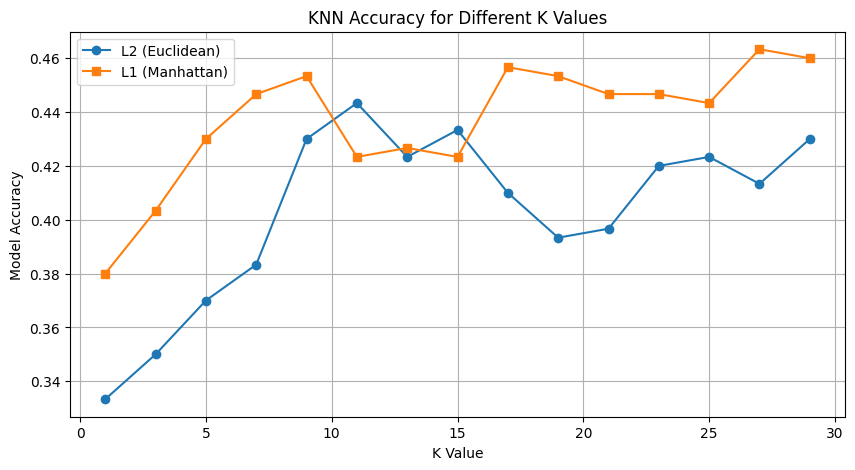

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, acc_l2, marker='o', label='L2 (Euclidean)')
plt.plot(k_values, acc_l1, marker='s', label='L1 (Manhattan)')
plt.xlabel("K Value")
plt.ylabel("Model Accuracy")
plt.title("KNN Accuracy for Different K Values")
plt.grid(True)
plt.legend()
plt.show()


## Discussion
The results show that the Manhattan distance performed better than the Euclidean distance. With L2 distance, the highest accuracy was **0.4433**, while L1 distance reached **0.4633** at K = 27.  
This means L1 distance worked better with the image features.

Accuracy improved as K increased and became more stable after K around 9.  
Higher K values reduced noise and gave smoother predictions.  
Overall accuracy stayed between **0.33 and 0.46**, which is expected for raw pixel data.

The dataset has **1024 features**, and no preprocessing was used.  
Because of this, KNN found it difficult to separate the classes clearly.

In summary, Manhattan distance gave the best results, and the model achieved a maximum accuracy of **46.33%**.  



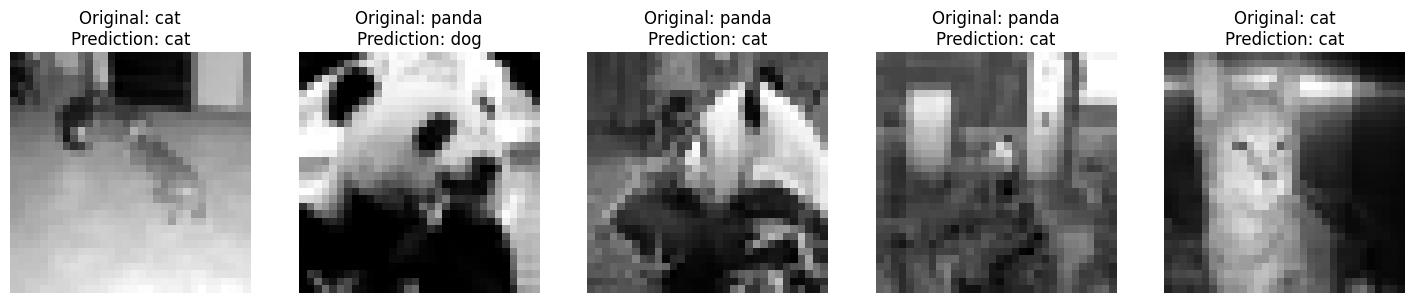

In [26]:
def show_predictions(data, labels, classes, k=3, metric="L2"):
    plt.figure(figsize=(18, 4))

    for i in range(5):
        idx = random.randint(0, len(data) - 1)
        x = data[idx]

        mask = np.arange(len(data)) != idx
        train_data = data[mask]
        train_labels = labels[mask]

        pred_label = knn(x, train_data, train_labels, k, metric)

        plt.subplot(1, 5, i + 1)
        plt.imshow(x.reshape(32, 32), cmap='gray')
        plt.title(
            f"Original: {classes[labels[idx]]}\nPrediction: {classes[pred_label]}"
        )
        plt.axis("off")

    plt.show()

show_predictions(data, labels, classes, k=3, metric="L2")
